In [1]:
import xarray as xr 
import glob 
import matplotlib.pyplot as plt
from scipy.signal import detrend

import numpy as np
import copy
import os 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle

import cartopy.crs as ccrs

from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

from scipy.optimize import linear_sum_assignment
from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# from eofs.xarray import Eof

import torch
from typing import Dict
from credit.physics_constants import RAD_EARTH, GRAVITY
from credit.physics_constants import RAD_EARTH, GRAVITY

import glob

from torch import nn
import numpy as np
import os

from credit.data import get_forward_data
from credit.transforms import load_transforms
from credit.physics_core import physics_pressure_level, physics_hybrid_sigma_level
from credit.physics_constants import (
    GRAVITY,
    RHO_WATER,
    LH_WATER,
    CP_DRY,
    CP_VAPOR,
)
from credit.postblock import GlobalEnergyFixer

import logging
import yaml
from credit.parser import credit_main_parser, predict_data_check
from dask.distributed import Client, get_client
import time

## Gather PRECT

In [2]:
# Get the current client if one exists and close it
try:
    client = get_client()
    client.close()
except ValueError:
    print("No active client found.")

client = Client()
print(f"Dask dashboard available at: {client.dashboard_link}")
time.sleep(12)  # Sleeps for 1 second

No active client found.
Dask dashboard available at: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/bingo/proxy/8787/status


In [3]:
%%time
conc = []
for yryr in range(1979,2014):
    print(f'doing {yryr}')
    DSdo_1 = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{yryr}_ERA5scaled_F32_Qtot.zarr')
    conc.append(DSdo_1)

print('... resampling and loading ....')
DSzarr1 = xr.concat(conc, dim='time')
DSzarr1_TP = DSzarr1[['TREFHT', 'PRECT']].load()
print('... resampled and loaded ....')

doing 1979
doing 1980
doing 1981
doing 1982
doing 1983
doing 1984
doing 1985
doing 1986
doing 1987
doing 1988
doing 1989
doing 1990
doing 1991
doing 1992
doing 1993
doing 1994
doing 1995
doing 1996
doing 1997
doing 1998
doing 1999
doing 2000
doing 2001
doing 2002
doing 2003
doing 2004
doing 2005
doing 2006
doing 2007
doing 2008
doing 2009
doing 2010
doing 2011
doing 2012
doing 2013
... resampling and loading ....
... resampled and loaded ....
CPU times: user 29.9 s, sys: 14.9 s, total: 44.8 s
Wall time: 46.9 s


In [4]:
%%time
# Compute annual max values
max_xrs = []
yr_append = []
for yryr in range(1979, 2013):
    DSyr = DSzarr1_TP.sel(time=str(yryr))  # Select data for the year
    max_xrs.append(DSyr.max(dim='time'))   # Compute max for the year
    yr_append.append(yryr)                 # Store the year

# Convert the list into an xarray DataArray with years as an index
annual_max_xr = xr.concat(max_xrs, dim=xr.DataArray(yr_append, dims='year', name='year'))

# Assign "year" as the coordinate
annual_max_xr = annual_max_xr.assign_coords(year=yr_append)

# Display the dataset
annual_max_xr


CPU times: user 29.9 s, sys: 294 ms, total: 30.2 s
Wall time: 27.4 s


<xarray.Dataset> Size: 15MB
Dimensions:    (year: 34, latitude: 192, longitude: 288)
Coordinates:
  * latitude   (latitude) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * longitude  (longitude) float32 1kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * year       (year) int64 272B 1979 1980 1981 1982 ... 2009 2010 2011 2012
Data variables:
    TREFHT     (year, latitude, longitude) float32 8MB 254.0 254.0 ... 274.1
    PRECT      (year, latitude, longitude) float32 8MB 0.00143 ... 0.003674

In [3]:
run_cell = True



if run_cell:
    print('CAMulator') 
    DSdt = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-02T00Z_OG/datetimes_in_files.nc')
    print(f"Dask dashboard available at: {client.dashboard_link}")
    
    
    
    def preprocess(ds):
        """
        Preprocess the dataset by selecting specific variables and a specific level.
        """
        return ds[['TREFHT', 'PRECT']]
    
    
    # verif_results_em = []
    max_df_=[]
    yryr_do = []
    for yryr in range(1989,2009):
        print(yryr)
        yryrstr = str(yryr)
        DS_indy = DSdt.sel(time=yryrstr)['index'].values
        FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-02T00Z_OG/pred_*.nc'))
        # Ensure DS_indy contains integers
        DS_indy = DS_indy.astype(int)
        
        # Validate indices (optional, but good practice)
        max_index = len(FNS) - 1
        if np.any(DS_indy > max_index) or np.any(DS_indy < 0):
            raise ValueError("Indices in DS_indy are out of bounds for the FNS list.")
        
        # Select files using DS_indy
        selected_files = [FNS[i] for i in DS_indy]
        #this is roughly 1450 files... 
    
        batch_size=500
        batches = [selected_files[i:i + batch_size] for i in range(0, len(selected_files), batch_size)]
        
        bingop = [] 
        
        for ee,batch in enumerate(batches):
            print(ee)
            DS_batch = xr.open_mfdataset(
                batch,
                preprocess=preprocess, parallel=True)  # Force loading within the loop to free memory
            
            bingop.append(DS_batch)
    
        DScesm = xr.concat(bingop, dim='time')
        print(f'length of file is {len(DScesm["time"])}')
    
        DScesm = DScesm.load()
        print('opened')
        max_df_.append(DScesm.max('time'))
        yryr_do.append(yryr)
        DScesm.max('time').to_netcdf(f'./extremes/camulator_maxes_PRECT_TREFHT_{yryr}.nc')
    
        
    
    # Convert the list into an xarray DataArray with years as an index
    annual_max_xr_camulator = xr.concat(max_df_, dim=xr.DataArray(yryr_do, dims='year', name='year'))
    
    # Assign "year" as the coordinate
    annual_max_xr_camulator = annual_max_xr_camulator.assign_coords(year=yryr_do)
    
    # Display the dataset
    annual_max_xr_camulator
else: 
    fillys = sorted(glob.glob('./extremes/camulator_maxes_PRECT_TREFHT_*.nc'))

    max_df_ = []
    yryr_do = [] 
    for fn in fillys: 
        max_df_.append(xr.open_dataset(fn))
        yryr_do.appennd(int(fn.split('_')[-1].split('.nc')[0]))
   
    # Convert the list into an xarray DataArray with years as an index
    annual_max_xr_camulator = xr.concat(max_df_, dim=xr.DataArray(yryr_do, dims='year', name='year'))
    
    # Assign "year" as the coordinate
    annual_max_xr_camulator = annual_max_xr_camulator.assign_coords(year=yryr_do)
    
    # Display the dataset
    annual_max_xr_camulator    

In [ ]:
# run_cell = True



# if run_cell:
#     print('CAMulator') 
#     DSdt = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-02T00Z_OG/datetimes_in_files.nc')
#     print(f"Dask dashboard available at: {client.dashboard_link}")
    
    
    
#     def preprocess(ds):
#         """
#         Preprocess the dataset by selecting specific variables and a specific level.
#         """
#         return ds[['TREFHT', 'PRECT']]
    
    
#     # verif_results_em = []
#     max_df_=[]
#     yryr_do = []
#     for yryr in range(1997,2009):
#         print(yryr)
#         yryrstr = str(yryr)
#         DS_indy = DSdt.sel(time=yryrstr)['index'].values
#         FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-02T00Z_OG/pred_*.nc'))
#         # Ensure DS_indy contains integers
#         DS_indy = DS_indy.astype(int)
        
#         # Validate indices (optional, but good practice)
#         max_index = len(FNS) - 1
#         if np.any(DS_indy > max_index) or np.any(DS_indy < 0):
#             raise ValueError("Indices in DS_indy are out of bounds for the FNS list.")
        
#         # Select files using DS_indy
#         selected_files = [FNS[i] for i in DS_indy]
#         #this is roughly 1450 files... 
    
#         batch_size=300
#         batches = [selected_files[i:i + batch_size] for i in range(0, len(selected_files), batch_size)]
        
#         bingop = [] 
        
#         for ee,batch in enumerate(batches):
#             print(ee)
#             DS_batch = xr.open_mfdataset(
#                 batch,
#                 preprocess=preprocess, parallel=True)  # Force loading within the loop to free memory
            
#             bingop.append(DS_batch)
    
#         DScesm = xr.concat(bingop, dim='time')
#         print(f'length of file is {len(DScesm["time"])}')
    
#         DScesm = DScesm.load()
#         print('opened')
#         max_df_.append(DScesm.min('time'))
#         yryr_do.append(yryr)
#         DScesm.max('time').to_netcdf(f'./extremes/camulator_mins_PRECT_TREFHT_{yryr}.nc')
    
        
    
#     # Convert the list into an xarray DataArray with years as an index
#     annual_max_xr_camulator = xr.concat(max_df_, dim=xr.DataArray(yryr_do, dims='year', name='year'))
    
#     # Assign "year" as the coordinate
#     annual_max_xr_camulator = annual_max_xr_camulator.assign_coords(year=yryr_do)
    
#     # Display the dataset
#     annual_max_xr_camulator
# else: 
#     fillys = sorted(glob.glob('./extremes/camulator_mins_PRECT_TREFHT_*.nc'))

#     min_df_ = []
#     yryr_do = [] 
#     for fn in fillys: 
#         min_df_.append(xr.open_dataset(fn))
#         yryr_do.appennd(int(fn.split('_')[-1].split('.nc')[0]))
   
#     # Convert the list into an xarray DataArray with years as an index
#     annual_mins_xr_camulator = xr.concat(min_df_, dim=xr.DataArray(yryr_do, dims='year', name='year'))
    
#     # Assign "year" as the coordinate
#     annual_mins_xr_camulator = annual_mins_xr_camulator.assign_coords(year=yryr_do)
    
#     # Display the dataset
#     annual_mins_xr_camulator    

In [3]:
%%time
import xarray as xr
import numpy as np
import glob
from dask.distributed import Client

# Start Dask client
print(f"Dask dashboard available at: {client.dashboard_link}")

print('CAMulator') 

# Open dataset with index values
DSdt = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-02T00Z_OG/datetimes_in_files.nc')

def preprocess(ds):
    return ds[['TREFHT', 'PRECT']]

max_df_ = []
yryr_do = []

for yryr in range(1998, 2009):
    print(f"Processing year: {yryr}")
    yryrstr = str(yryr)

    # Ensure indices are valid integers
    DS_indy = DSdt.sel(time=yryrstr)['index'].values.astype(int)
    
    # Retrieve file list
    FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-02T00Z_OG/pred_*.nc'))
    
    # Validate indices
    max_index = len(FNS) - 1
    if np.any(DS_indy > max_index) or np.any(DS_indy < 0):
        raise ValueError(f"Indices in DS_indy are out of bounds: max index {max_index}")

    selected_files = [FNS[i] for i in DS_indy]
    print(f"Processing {len(selected_files)} files for {yryr}")

    batch_size = 120  # Reduce batch size to avoid open file limits
    batches = [selected_files[i:i + batch_size] for i in range(0, len(selected_files), batch_size)]

    bingop = [] 

    for ee, batch in enumerate(batches):
        print(f"Batch {ee+1}/{len(batches)}")

        datasets = []
        for f in batch:
            try:
                with xr.open_dataset(f) as ds:  # Explicitly closing files after reading
                    datasets.append(ds.load())  # Load data into memory
            except Exception as e:
                print(f"Error opening file {f}: {e}")

        DS_batch = xr.concat(datasets, dim="time")  # Concatenate after loading
        bingop.append(DS_batch)

    DScesm = xr.concat(bingop, dim='time')
    print(f'length of file is {len(DScesm["time"])}')

    DScesm = DScesm.load()
    print('opened')
    max_df_.append(DScesm.min('time'))
    yryr_do.append(yryr)

    # Write to NetCDF (explicitly closing file after writing)
    output_file = f'./extremes/camulator_mins_PRECT_TREFHT_{yryr}.nc'
    DScesm.max('time').to_netcdf(output_file)
    print(f"Saved: {output_file}")
    break

# Convert to xarray DataArray
annual_max_xr_camulator = xr.concat(max_df_, dim=xr.DataArray(yryr_do, dims='year', name='year'))
annual_max_xr_camulator = annual_max_xr_camulator.assign_coords(year=yryr_do)

# Display dataset
annual_max_xr_camulator


Dask dashboard available at: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/bingo/proxy/8787/status
CAMulator
Processing year: 1998
Processing 1460 files for 1998
Batch 1/13
Batch 2/13
Batch 3/13
Batch 4/13
Batch 5/13
Batch 6/13
Batch 7/13
Batch 8/13
Batch 9/13
Batch 10/13
Batch 11/13
Batch 12/13
Batch 13/13
length of file is 1460
opened
Saved: ./extremes/camulator_mins_PRECT_TREFHT_1998.nc
CPU times: user 3min 25s, sys: 1min 41s, total: 5min 7s
Wall time: 7min 28s


<xarray.Dataset> Size: 64MB
Dimensions:    (year: 1, level: 32, latitude: 192, longitude: 288)
Coordinates:
  * level      (level) int64 256B 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
  * latitude   (latitude) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * longitude  (longitude) float32 1kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * year       (year) int64 8B 1998
Data variables: (12/21)
    U          (year, level, latitude, longitude) float64 14MB -18.33 ... -7.54
    V          (year, level, latitude, longitude) float64 14MB -44.35 ... -7.831
    T          (year, level, latitude, longitude) float64 14MB 167.7 ... 239.7
    Qtot       (year, level, latitude, longitude) float64 14MB 3.173e-06 ... ...
    PS         (year, latitude, longitude) float64 442kB 6.681e+04 ... 9.926e+04
    TREFHT     (year, latitude, longitude) float64 442kB 211.3 211.6 ... 238.8
    ...         ...
    FSNS       (year, latitude, longitude) float64 442kB -1.393e+05 ... -9.01...
    FLNS       (year, latitude, longitude) float64 442kB -1.523e+06 ... -1.28...
    FSNT       (year, latitude, longitude) float64 442kB -3.016e+05 ... -4.83...
    FLNT       (year, latitude, longitude) float64 442kB -3.987e+06 ... -5.09...
    SHFLX      (year, latitude, longitude) float64 442kB -1.527e+05 ... -7.01...
    LHFLX      (year, latitude, longitude) float64 442kB -2.388e+05 ... -3.64...

## Gather Files

In [2]:
%%time
conc = []
for yryr in range(1979,2014):
    print(f'doing {yryr}')
    DSdo_1 = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{yryr}_ERA5scaled_F32_Qtot.zarr')
    conc.append(DSdo_1)

print('... resampling and loading ....')
DSzarr1 = xr.concat(conc, dim='time')
DSzarr1_TP = DSzarr1[['TREFHT', 'PRECT']].load()
print('... resampled and loaded ....')

# Compute annual max values
max_xrs = []
yr_append = []
for yryr in range(1979, 2013):
    DSyr = DSzarr1_TP.sel(time=str(yryr))  # Select data for the year
    max_xrs.append(DSyr.max(dim='time'))   # Compute max for the year
    yr_append.append(yryr)                 # Store the year

# Convert the list into an xarray DataArray with years as an index
annual_max_xr = xr.concat(max_xrs, dim=xr.DataArray(yr_append, dims='year', name='year'))

# Assign "year" as the coordinate
annual_max_xr = annual_max_xr.assign_coords(year=yr_append)

# Display the dataset
annual_max_xr


doing 1979
doing 1980
doing 1981
doing 1982
doing 1983
doing 1984
doing 1985
doing 1986
doing 1987
doing 1988
doing 1989
doing 1990
doing 1991
doing 1992
doing 1993
doing 1994
doing 1995
doing 1996
doing 1997
doing 1998
doing 1999
doing 2000
doing 2001
doing 2002
doing 2003
doing 2004
doing 2005
doing 2006
doing 2007
doing 2008
doing 2009
doing 2010
doing 2011
doing 2012
doing 2013
... resampling and loading ....
... resampled and loaded ....
CPU times: user 1min 7s, sys: 32 s, total: 1min 39s
Wall time: 1min 8s


<xarray.Dataset> Size: 15MB
Dimensions:    (year: 34, latitude: 192, longitude: 288)
Coordinates:
  * latitude   (latitude) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * longitude  (longitude) float32 1kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * year       (year) int64 272B 1979 1980 1981 1982 ... 2009 2010 2011 2012
Data variables:
    TREFHT     (year, latitude, longitude) float32 8MB 254.0 254.0 ... 274.1
    PRECT      (year, latitude, longitude) float32 8MB 0.00143 ... 0.003674

## Gather Saved Camulator files

In [3]:
fillys = sorted(glob.glob('./extremes/camulator_maxes_PRECT_TREFHT_*.nc'))

max_df_ = []
yryr_do = [] 
for fn in fillys: 
    max_df_.append(xr.open_dataset(fn))
    yryr_do.append(int(fn.split('_')[-1].split('.nc')[0]))

# Convert the list into an xarray DataArray with years as an index
annual_max_xr_camulator = xr.concat(max_df_, dim=xr.DataArray(yryr_do, dims='year', name='year'))

# Assign "year" as the coordinate
annual_max_xr_camulator = annual_max_xr_camulator.assign_coords(year=yryr_do)

# Display the dataset
annual_max_xr_camulator    

<xarray.Dataset> Size: 27MB
Dimensions:    (year: 30, latitude: 192, longitude: 288)
Coordinates:
  * latitude   (latitude) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * longitude  (longitude) float32 1kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * year       (year) int64 240B 1979 1980 1981 1982 ... 2005 2006 2007 2008
Data variables:
    TREFHT     (year, latitude, longitude) float64 13MB 246.1 246.4 ... 272.6
    PRECT      (year, latitude, longitude) float64 13MB 0.001075 ... 0.001553

## Plot it

In [5]:
# Display the dataset
client.close()

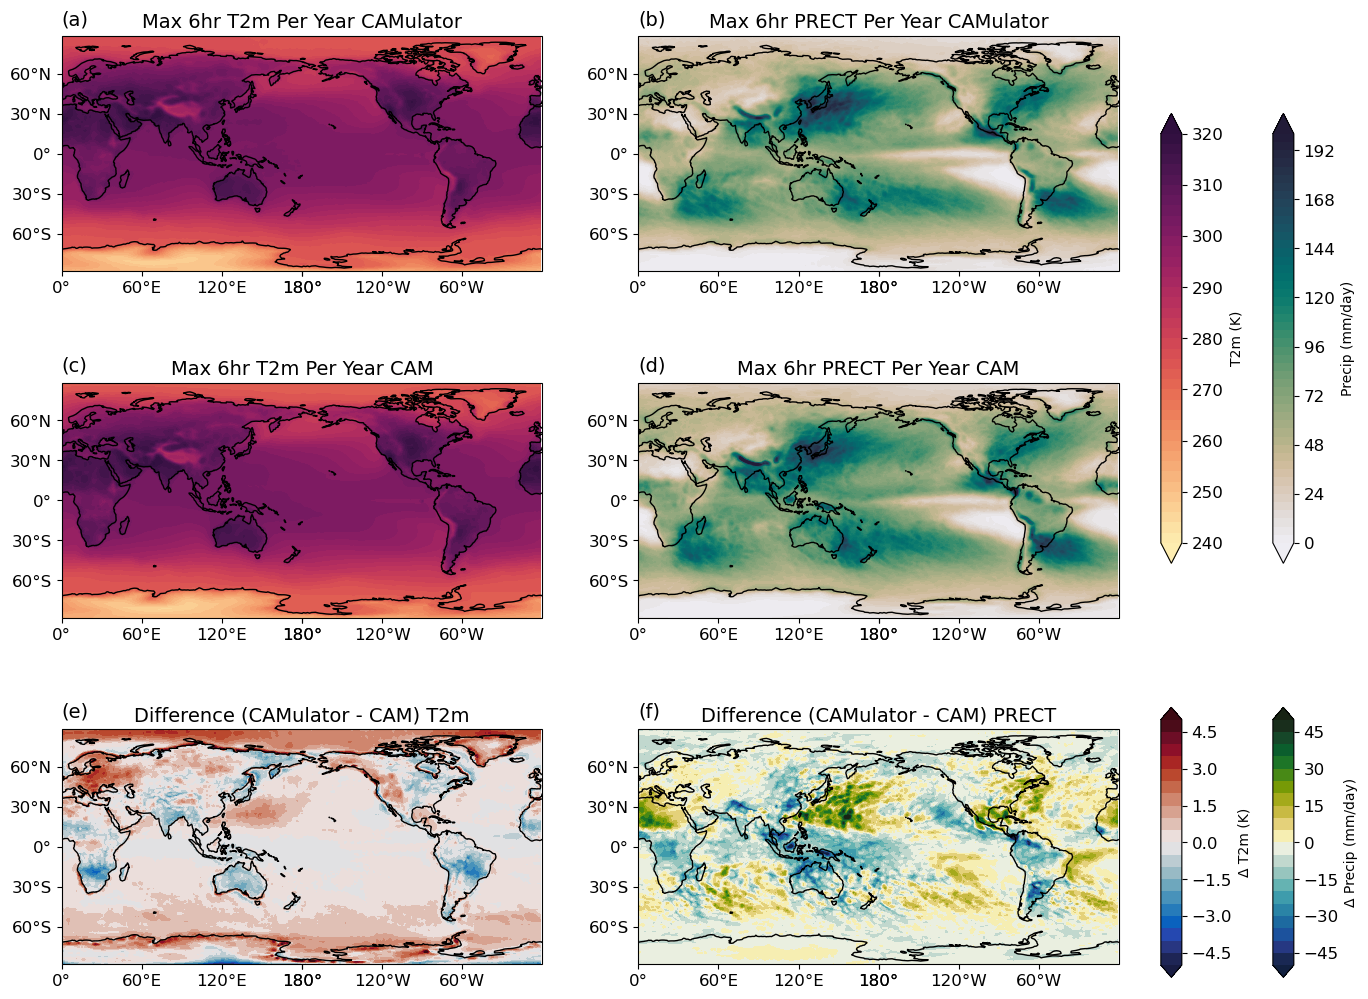

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cmocean
import cmocean.cm as cmo

# Compute annual means for both models
annual_max_xr_cesm_t2m = annual_max_xr['TREFHT'].mean('year')
annual_max_xr_cesm_prect = annual_max_xr['PRECT'].mean('year') * 4000
annual_max_xr_camulator_t2m = annual_max_xr_camulator['TREFHT'].mean('year')
annual_max_xr_camulator_prect = annual_max_xr_camulator['PRECT'].mean('year') * 4000

# Compute differences (CAMulator - CAM)
diff_t2m = annual_max_xr_camulator_t2m - annual_max_xr_cesm_t2m
diff_prect = annual_max_xr_camulator_prect - annual_max_xr_cesm_prect

# Data for visualization
data = [
    annual_max_xr_camulator_t2m, annual_max_xr_camulator_prect,
    annual_max_xr_cesm_t2m, annual_max_xr_cesm_prect,
    diff_t2m, diff_prect
]

# Define levels for contour plots
levels_prect = np.linspace(0, 200, 51)  # Precipitation
levels_t2m = np.linspace(240, 320, 41)  # Temperature
levels_diff_t2m = np.linspace(-5, 5, 21)  # Difference in Temperature
levels_diff_prect = np.linspace(-50, 50, 21)  # Difference in Precip

# Create figure with six panels (3 rows, 2 columns)
proj = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(nrows=3, ncols=2, subplot_kw={'projection': proj}, figsize=(14, 18))

# Titles for plots
titles = [
    'Max 6hr T2m Per Year CAMulator',
    'Max 6hr PRECT Per Year CAMulator',
    'Max 6hr T2m Per Year CAM',
    'Max 6hr PRECT Per Year CAM',
    'Difference (CAMulator - CAM) T2m',
    'Difference (CAMulator - CAM) PRECT'
]
# Labels (column-wise order)
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']


num_count = 0

for ax, title, plot_data, label  in zip(axes.flat, titles, data, labels):

    if num_count in [0, 2]:  # Temperature plots
        im_t2m = ax.contourf(
            plot_data.longitude, plot_data.latitude, plot_data,
            levels=levels_t2m,
            transform=ccrs.PlateCarree(),
            cmap=cmo.matter,
            extend='both'
        )
    elif num_count in [1, 3]:  # Precipitation plots
        im_prect = ax.contourf(
            plot_data.longitude, plot_data.latitude, plot_data,
            levels=levels_prect,
            transform=ccrs.PlateCarree(),
            cmap=cmo.rain,
            extend='both'
        )
    else:  # Difference plots (T2m & Precip)
        if num_count == 4:  # T2m Difference
            im_diff_t2m = ax.contourf(
                plot_data.longitude, plot_data.latitude, plot_data,
                levels=levels_diff_t2m,
                transform=ccrs.PlateCarree(),
                cmap=cmo.balance,
                extend='both'
            )
        else:  # Precip Difference
            im_diff_prect = ax.contourf(
                plot_data.longitude, plot_data.latitude, plot_data,
                levels=levels_diff_prect,
                transform=ccrs.PlateCarree(),
                cmap=cmo.delta,
                extend='both'
            )

    ax.coastlines()
    ax.set_title(title, fontsize=14)

    # Set lat/lon ticks with degree symbols
    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.set_extent([0, 360, -88, 88], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(labelsize=12)
    ax.text(0.0, 1.05, label, transform=ax.transAxes, fontsize=14,)

    num_count += 1

# Adjust layout and add colorbars
fig.subplots_adjust(right=0.88, wspace=0.2, hspace=-0.5)

# Create colorbars
cbar_ax_t2m = fig.add_axes([0.91, 0.46, 0.015, 0.25])
cbar_t2m = fig.colorbar(im_t2m, cax=cbar_ax_t2m, label='T2m (K)', shrink=0.8)
cbar_t2m.ax.tick_params(labelsize=12)

cbar_ax_prect = fig.add_axes([0.99, 0.46, 0.015, 0.25])
cbar_prect = fig.colorbar(im_prect, cax=cbar_ax_prect, label='Precip (mm/day)', shrink=0.8)
cbar_prect.ax.tick_params(labelsize=12)

cbar_ax_diff_t2m = fig.add_axes([0.91, 0.23, 0.015, 0.15])
cbar_diff_t2m = fig.colorbar(im_diff_t2m, cax=cbar_ax_diff_t2m, label='Δ T2m (K)', shrink=0.8)
cbar_diff_t2m.ax.tick_params(labelsize=12)

cbar_ax_diff_prect = fig.add_axes([0.99, 0.23, 0.015, 0.15])
cbar_diff_prect = fig.colorbar(im_diff_prect, cax=cbar_ax_diff_prect, label='Δ Precip (mm/day)', shrink=0.8)
cbar_diff_prect.ax.tick_params(labelsize=12)
filename='Extremes_T2m_Prect.png'
plt.savefig(filename, dpi=250, bbox_inches='tight')
plt.show()


## Metrics - Daily Data

## Gather Yearly Data

In [13]:
# Get the current client if one exists and close it
try:
    client = get_client()
    client.close()
except ValueError:
    print("No active client found.")

client = Client()
print(f"Dask dashboard available at: {client.dashboard_link}")
time.sleep(19)  # Sleeps for 1 second

No active client found.
Dask dashboard available at: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/Grow/proxy/8787/status


In [15]:
%%time
conc = []
for yryr in range(1979,2014):
    print(f'doing {yryr}')
    DSdo_1 = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{yryr}_ERA5scaled_F32_Qtot.zarr')
    conc.append(DSdo_1)

print('... resampling and loading ....')
DSzarr1 = xr.concat(conc, dim='time')
DSzarr1_TP = DSzarr1[['U', 'TREFHT', 'PRECT','PS','T','V', 'Qtot']].isel(level=[15,20,31]).resample(time='1D').mean().load()
print('... resampled and loaded ....')

FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-02T00Z_OG/1D/averaged_UVTQtotPSPRECTTREFHT*'))
print('... opening model run ...')
DSs = xr.open_mfdataset(FNS)
DSs = DSs.isel(level=[15,20,31])
print('... taking mean ...')
DSsm = DSs.mean('time').load()
DSzarr1_TPm = DSzarr1_TP.mean('time').load()
DSzarr1_TPm['level']=DSsm['level']
DSzarr1_TP['level']=DSsm['level']

doing 1979
doing 1980
doing 1981
doing 1982
doing 1983
doing 1984
doing 1985
doing 1986
doing 1987
doing 1988
doing 1989
doing 1990
doing 1991
doing 1992
doing 1993
doing 1994
doing 1995
doing 1996
doing 1997
doing 1998
doing 1999
doing 2000
doing 2001
doing 2002
doing 2003
doing 2004
doing 2005
doing 2006
doing 2007
doing 2008
doing 2009
doing 2010
doing 2011
doing 2012
doing 2013
... resampling and loading ....


/glade/work/wchapman/conda-envs/credit-dk-casper/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 61.57 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


... resampled and loaded ....
... opening model run ...
... taking mean ...
CPU times: user 9min 20s, sys: 1min 1s, total: 10min 22s
Wall time: 15min 44s


## My Data

data shape: (288, 192, 4015)
lat shape: (192,)
lon shape: (288,)
data shape: (288, 192, 4015)
lat shape: (192,)
lon shape: (288,)
data shape: (288, 192, 5843)
lat shape: (192,)
lon shape: (288,)
starting thispam
return thispam
dist1
starting thispam
return thispam
dist2
starting thispam
return thispam
Rain amount of average distribution
  peak: 11.4 mm/d
  width: 2.9 r2/r1
Rain frequency of average distribution
  peak: 2.4 mm/d
  width: 4.4 r2/r1


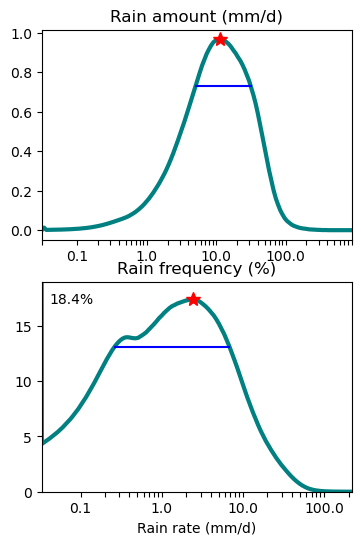

KeyboardInterrupt: 

In [16]:
%%time
import os
import sys
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt

L = 2.5e6  # Latent heat of vaporization of water (W/m²)
wm2tommd = 1.0 / L * 3600 * 24  # Conversion from W/m² to mm/d

pdata1 = DSzarr1_TP.sel(time=slice('1980','1990'))['PRECT'].values*4000
pdata1 = np.transpose(pdata1, (2, 1, 0))
lat = DSzarr1_TP['latitude'].values
lon = DSzarr1_TP['longitude'].values

print('data shape:', pdata1.shape)
print('lat shape:', lat.shape)
print('lon shape:', lon.shape)

pdata2 = DSs['PRECT'].sel(time=slice('1980','1990')).values*4000
pdata2 = np.transpose(pdata2, (2, 1, 0))

print('data shape:', pdata2.shape)
print('lat shape:', lat.shape)
print('lon shape:', lon.shape)


pdata3 = xr.open_dataset('/glade/campaign/cgd/amp/wchapman/Reanalysis/GPCP/GPCP_global_1997_2012.camgrid.nc')['precip'].values
pdata3 = np.transpose(pdata3, (2, 1, 0))
print('data shape:', pdata3.shape)
print('lat shape:', lat.shape)
print('lon shape:', lon.shape)

#thanks dr. pendergrass: --> adapted to python3
def calcrainmetrics(pdistin,bincrates):
    ### This calculation can be applied to rain amount or rain frequency distributions 
    ### Here we'll do it for a distribution averaged over a region, but you could also do it at each grid point
    pdist=np.copy(pdistin)
    tile=np.array(0.1) # this is the threshold, 10% of rain amount or rain frequency
    pdist[0]=0 # If this is frequency, get rid of the dry frequency. If it's amount, it should already be zero or close to it.
    pmax=pdist.max()
    if pmax>0:
        imax=np.nonzero(pdist==pmax)
        rmax=np.interp(imax,range(0,len(bincrates)),bincrates)
        rainpeak=rmax[0][0]
        ### we're going to find the width by summing downward from pmax to lines at different heights, and then interpolating to figure out the rain rates that intersect the line. 
        theps=np.linspace(0.1,.99,99)*pmax
        thefrac=np.empty(theps.shape) 
        for i in range(len(theps)):
            thisp=theps[i]
            overp=(pdist-thisp)*(pdist> thisp);
            thefrac[i]=sum(overp)/sum(pdist)
        ptilerain=np.interp(-tile,-thefrac,theps) 
        #ptilerain/db ### check this against rain amount plot
        #ptilerain*100/db ### check this against rain frequency plot
        diffraintile=(pdist-ptilerain);
        alli=np.nonzero(diffraintile>0)
        afterfirst=alli[0][0]
        noistart=np.nonzero(diffraintile[0:afterfirst]<0)
        beforefirst=noistart[0][len(noistart[0])-1]
        incinds=range(beforefirst,afterfirst+1)
        ### need error handling on these for when inter doesn't behave well and there are multiple crossings
        if np.all(np.diff(diffraintile[incinds]) > 0):
            r1=np.interp(0,diffraintile[incinds],incinds) # this is ideally what happens. note: r1 is a bin index, not a rain rate. 
        else:
            r1=np.average(incinds) # in case interp won't return something meaningful, we use this kluge. 
        beforelast=alli[0][len(alli[0])-1]
        noiend=np.nonzero(diffraintile[beforelast:(len(diffraintile)-1)]<0)+beforelast
        afterlast=noiend[0][0]
        decinds=range(beforelast,afterlast+1)
        if np.all(np.diff(-diffraintile[decinds]) > 0):
            r2=np.interp(0,-diffraintile[decinds],decinds)
        else:
            r2=np.average(decinds) 
        ### Bin width - needed to normalize the rain amount distribution                                                                                                                
        db=(bincrates[2]-bincrates[1])/bincrates[1];
        rainwidth=(r2-r1)*db+1
        return rainpeak,rainwidth,(imax[0][0],pmax),(r1,r2,ptilerain)
    else:
        return 0,0,(0,pmax),(0,0,0)

def makedists(pdata,binl):
    ##### This is called from within makeraindist.
    ##### Caclulate distributions 
    pds=pdata.shape;    nlat=pds[1];    nlon=pds[0];    nd=pds[2]
    bins=np.append(0,binl)
    n=np.empty((nlon,nlat,len(binl)))
    binno=np.empty(pdata.shape)
    for ilon in range(nlon):
        for ilat in range(nlat):
            # this is the histogram - we'll get frequency from this
            thisn,thisbin=np.histogram(pdata[ilon,ilat,:],bins) 
            n[ilon,ilat,:]=thisn
            # these are the bin locations. we'll use these for the amount dist
            binno[ilon,ilat,:]=np.digitize(pdata[ilon,ilat,:],bins) 
    #### Calculate the number of days with non-missing data, for normalization
    ndmat = np.nansum(n, axis=2, keepdims=True)  # Avoids redundant copying
    print('starting thispam')
    # Vectorized computation for precipitation amount distribution
    testpamtmap = np.sum(pdata[..., np.newaxis] * (binno[..., np.newaxis] == np.arange(len(bins) - 1)),
        axis=2)
    
    # Safe division
    thispamtmap = np.where(ndmat > 0, testpamtmap / ndmat, 0)
    print('return thispam')
    
    return n / ndmat, thispamtmap  # Probability & rain amount distributions

sp1=pdata1.shape
if (sp1[1]!=len(lat))&(sp1[0]!=len(lon)):
    print('pdata1 should be [days,lon,lat]')
pmax=pdata1.max()/wm2tommd
maxp=1500;# % choose an arbitrary upper bound for initial distribution, in w/m2
minp=1;# % arbitrary lower bound, in w/m2. Make sure to set this low enough that you catch most of the rain. 
nbins=100;
binrlog=np.linspace(np.log(minp),np.log(maxp),nbins);
dbinlog=np.diff(binrlog);
binllog=binrlog-dbinlog[0];
binr=np.exp(binrlog)/L*3600*24;
binl=np.exp(binllog)/L*3600*24;
dbin=dbinlog[0];
binrlogex=binrlog;
binrend=np.exp(binrlogex[len(binrlogex)-1])

while maxp>binr[len(binr)-1]:
    binrlogex=np.append(binrlogex,binrlogex[len(binrlogex)-1]+dbin)
    binrend=np.exp(binrlogex[len(binrlogex)-1]);
    binrlog=binrlogex;
    binllog=binrlog-dbinlog[0];
    binl=np.exp(binllog)/L*3600*24; #%% this is what we'll use to make distributions
    binr=np.exp(binrlog)/L*3600*24;
bincrates=np.append(0,(binl+binr)/2)# % we'll use this for plotting.
    #### 2. Calculate distributions 


ppdfmap,pamtmap=makedists(pdata1,binl);
print('dist1')
ppdfmap_camulator,pamtmap_camulator=makedists(pdata2,binl);
print('dist2')
ppdfmap_gpcp, pamtmap_gpcp = makedists(pdata3,binl);


#### 3. Spatially average distributions
weight=np.tile(np.cos(lat*np.pi/180),(len(lon),1));
weight=weight/weight.sum()
weightp=np.tile(np.expand_dims(weight,axis=2),(1,1,ppdfmap.shape[2]))
ppdf1=np.nansum(np.nansum(ppdfmap*weightp,axis=0),axis=0)
pamt1=np.nansum(np.nansum(pamtmap*weightp,axis=0),axis=0)

weight=np.tile(np.cos(lat*np.pi/180),(len(lon),1));
weight=weight/weight.sum()
weightp=np.tile(np.expand_dims(weight,axis=2),(1,1,ppdfmap_camulator.shape[2]))
ppdf2=np.nansum(np.nansum(ppdfmap_camulator*weightp,axis=0),axis=0)
pamt2=np.nansum(np.nansum(pamtmap_camulator*weightp,axis=0),axis=0)

weight=np.tile(np.cos(lat*np.pi/180),(len(lon),1));
weight=weight/weight.sum()
weightp=np.tile(np.expand_dims(weight,axis=2),(1,1,ppdfmap_gpcp.shape[2]))
ppdf3=np.nansum(np.nansum(ppdfmap_gpcp*weightp,axis=0),axis=0)
pamt3=np.nansum(np.nansum(pamtmap_gpcp*weightp,axis=0),axis=0)


#### Calculate the rain metrics for the averaged distribution
rainamtpeak,rainamtwidth,plotpeakamt,plotwidthamt=calcrainmetrics(pamt1, bincrates)
rainpdfpeak,rainpdfwidth,plotpeakfreq,plotwidthfreq=calcrainmetrics(ppdf1, bincrates)
rainamtpeak_camu,rainamtwidth_camu,plotpeakamt_camu,plotwidthamt_camu=calcrainmetrics(pamt2, bincrates)
rainpdfpeak_camu,rainpdfwidth_camu,plotpeakfreq_camu,plotwidthfreq_camu=calcrainmetrics(ppdf2, bincrates)
rainamtpeak_gpcp,rainamtwidth_gpcp,plotpeakamt_gpcp,plotwidthamt_gpcp=calcrainmetrics(pamt3, bincrates)
rainpdfpeak_gpcp,rainpdfwidth_gpcp,plotpeakfreq_gpcp,plotwidthfreq_gpcp=calcrainmetrics(ppdf3, bincrates)


print("Rain amount of average distribution")
print(f'  peak: {rainamtpeak:.1f} mm/d')
print(f'  width: {rainamtwidth:.1f} r2/r1')
print("Rain frequency of average distribution")
print(f'  peak: {rainpdfpeak:.1f} mm/d')
print(f'  width: {rainpdfwidth:.1f} r2/r1')

dry=ppdf1[0]*100 # Change in dry days
# % rain rates in mm/d for x axis ticks and labeling 
otn=np.linspace(1,9,9)
xtickrates=np.append(0,otn*.1)
xtickrates=np.append(xtickrates,otn)
xtickrates=np.append(xtickrates,otn*10)
xtickrates=np.append(xtickrates,otn*100)
xticks=np.interp(xtickrates,bincrates,range(0,len(bincrates))); #% bin numbers associated with nice number rain rate
xticks,indices=np.unique(xticks,return_index=True)
xtickrates=xtickrates[indices]
### Bin width - needed to normalize the rain amount distribution
db=(bincrates[2]-bincrates[1])/bincrates[1];



### Now we plot
plt.figure(figsize=(4,6))
plt.clf()
ax=plt.subplot(211)
plt.plot(range(0,len(pamt1)),pamt1/db, 'teal',linewidth=3)
plt.plot(plotpeakamt[0],plotpeakamt[1]/db,'r*',markersize=10,mec='r')
plt.plot((plotwidthamt[0],plotwidthamt[1]),(plotwidthamt[2]/db,plotwidthamt[2]/db),'b');
plt.xlim((4,130))
plt.setp(ax, xticks=xticks, xticklabels=[str(rate) if i % 9 == 1 else '' for i, rate in enumerate(xtickrates)])
plt.title('Rain amount (mm/d)')
ax=plt.subplot(212)
plt.plot(range(0,len(ppdf1)),ppdf1/db*100, 'teal',linewidth=3)
plt.plot(plotpeakfreq[0],plotpeakfreq[1]/db*100,'r*',markersize=10,mec='r')
plt.plot((plotwidthfreq[0],plotwidthfreq[1]),(plotwidthfreq[2]*100/db,plotwidthfreq[2]*100/db),'b');
plt.ylim((0,19))

### Annotate with the dry day frequency
ymin, ymax = ax.get_ylim()
t=plt.text(4,ymax*0.95, "{:.1f}".format(dry)+'%')
plt.setp(t,va='top',ha='left')
plt.setp(ax, xticks=xticks, xticklabels=[str(rate) if i % 9 == 1 else '' for i, rate in enumerate(xtickrates)])
plt.xlim((1,120))

plt.xlabel('Rain rate (mm/d)')
plt.title('Rain frequency (%)')
filename="rainmetricdemo_averagedist.png"

plt.savefig(filename, dpi=250, bbox_inches='tight')
# print "wrote "+filename
plt.show()
plt.close()


# ### now we'll make maps of the metrics to examine their spatial pattern. 

# ### Calculate the metrics for the distribution at each grid point
# # ppdfmap,pamtmap=makedists(pdata1,binl);
# amtpeakmap=np.empty((len(lon),len(lat)))
# pdfpeakmap=np.empty((len(lon),len(lat)))
# amtwidthmap=np.empty((len(lon),len(lat)))
# pdfwidthmap=np.empty((len(lon),len(lat)))
# for i in range(len(lon)):
#     for j in range(len(lat)):
#         rainpeak,rainwidth,plotpeak,plotwidth=calcrainmetrics(pamtmap[i,j,:],bincrates)
#         amtpeakmap[i,j]=rainpeak
#         amtwidthmap[i,j]=rainwidth
#         rainpeak,rainwidth,plotpeak,plotwidth=calcrainmetrics(ppdfmap[i,j,:],bincrates)
#         pdfpeakmap[i,j]=rainpeak
#         pdfwidthmap[i,j]=rainwidth


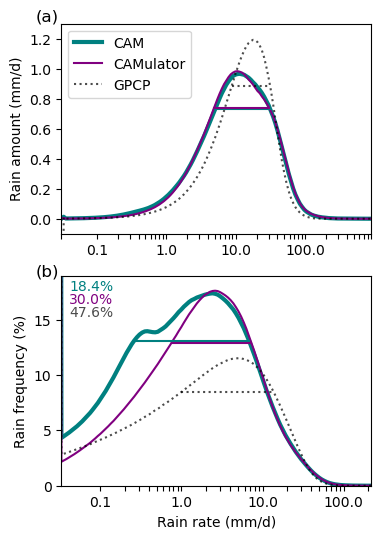

In [47]:
dry1=ppdf1[0]*100 # Change in dry days
dry2=ppdf2[0]*100 # Change in dry days
dry3=ppdf3[0]*100 # Change in dry days

plt.figure(figsize=(4,6))
plt.clf()
ax=plt.subplot(211)
plt.plot(range(0,len(pamt1)),pamt1/db, 'teal',linewidth=3, label='CAM')
plt.plot(range(0,len(pamt2)),pamt2/db, 'purple',linewidth=1.5, label='CAMulator')
plt.plot(range(0,len(pamt3)),pamt3/db, 'k',alpha=0.7,linewidth=1.5, linestyle=':', label='GPCP')
plt.legend()
# plt.plot(plotpeakamt[0],plotpeakamt[1]/db,'r*',markersize=10,mec='r')
plt.plot((plotwidthamt[0],plotwidthamt[1]),(plotwidthamt[2]/db,plotwidthamt[2]/db),'teal');
plt.plot((plotwidthamt_camu[0],plotwidthamt_camu[1]),(plotwidthamt_camu[2]/db,plotwidthamt_camu[2]/db),'purple');
plt.plot((plotwidthamt_gpcp[0],plotwidthamt_gpcp[1]),(plotwidthamt_gpcp[2]/db,plotwidthamt_gpcp[2]/db),'k',alpha=0.7, linestyle=':');

plt.xlim((4,130))
plt.ylim((-.1,1.3))

plt.setp(ax, xticks=xticks, xticklabels=[str(rate) if i % 9 == 1 else '' for i, rate in enumerate(xtickrates)])
plt.ylabel('Rain amount (mm/d)')
ax=plt.subplot(212)
plt.plot(range(0,len(ppdf1)),ppdf1/db*100, 'teal',linewidth=3)
plt.plot(range(0,len(ppdf2)),ppdf2/db*100, 'purple',linewidth=1.5)
plt.plot(range(0,len(ppdf3)),ppdf3/db*100, 'k',alpha=0.7,linewidth=1.5, linestyle=':')

# plt.plot(plotpeakfreq[0],plotpeakfreq[1]/db*100,'r*',markersize=10,mec='r')
plt.plot((plotwidthfreq[0],plotwidthfreq[1]),(plotwidthfreq[2]*100/db,plotwidthfreq[2]*100/db),'teal');
plt.plot((plotwidthfreq_camu[0],plotwidthfreq_camu[1]),(plotwidthfreq_camu[2]*100/db,plotwidthfreq_camu[2]*100/db),'purple');
plt.plot((plotwidthfreq_gpcp[0],plotwidthfreq_gpcp[1]),(plotwidthfreq_gpcp[2]*100/db,plotwidthfreq_gpcp[2]*100/db),'k',alpha=0.7, linestyle=':')

plt.ylim((0,19))

### Annotate with the dry day frequency
ymin, ymax = ax.get_ylim()
t=plt.text(4,ymax*0.93, "{:.1f}".format(dry1)+'%',color='teal')
t=plt.text(4,ymax*0.87, "{:.1f}".format(dry2)+'%',color='purple')
t=plt.text(4,ymax*0.86, "{:.1f}".format(dry3)+'%',color='k', alpha=0.7)
plt.text(-9.0, 19, '(b)', fontsize=12,)
plt.text(-9.0, 42, '(a)', fontsize=12,)

plt.setp(t,va='top',ha='left')
plt.setp(ax, xticks=xticks, xticklabels=[str(rate) if i % 9 == 1 else '' for i, rate in enumerate(xtickrates)])
plt.xlim((1,120))

plt.xlabel('Rain rate (mm/d)')
plt.ylabel('Rain frequency (%)')
filename="rainmetricdemo_averagedist.png"

plt.savefig(filename, dpi=250, bbox_inches='tight')
# print "wrote "+filename
plt.show()
plt.close()


In [166]:
### Calculate the metrics for the distribution at each grid point
# ppdfmap,pamtmap=makedists(pdata1,binl);
amtpeakmap1=np.empty((len(lon),len(lat)))
pdfpeakmap1=np.empty((len(lon),len(lat)))
amtwidthmap1=np.empty((len(lon),len(lat)))
pdfwidthmap1=np.empty((len(lon),len(lat)))

amtpeakmap2=np.empty((len(lon),len(lat)))
pdfpeakmap2=np.empty((len(lon),len(lat)))
amtwidthmap2=np.empty((len(lon),len(lat)))
pdfwidthmap2=np.empty((len(lon),len(lat)))

amtpeakmap3=np.empty((len(lon),len(lat)))
pdfpeakmap3=np.empty((len(lon),len(lat)))
amtwidthmap3=np.empty((len(lon),len(lat)))
pdfwidthmap3=np.empty((len(lon),len(lat)))


for i in range(len(lon)):
    if (i%50) ==0:
        print(i)
    for j in range(len(lat)):
        rainpeak,rainwidth,plotpeak,plotwidth=calcrainmetrics(pamtmap[i,j,:],bincrates)
        amtpeakmap1[i,j]=rainpeak
        amtwidthmap1[i,j]=rainwidth
        rainpeak,rainwidth,plotpeak,plotwidth=calcrainmetrics(ppdfmap[i,j,:],bincrates)
        pdfpeakmap1[i,j]=rainpeak
        pdfwidthmap1[i,j]=rainwidth

        rainpeak,rainwidth,plotpeak,plotwidth=calcrainmetrics(pamtmap_camulator[i,j,:],bincrates)
        amtpeakmap2[i,j]=rainpeak
        amtwidthmap2[i,j]=rainwidth
        rainpeak,rainwidth,plotpeak,plotwidth=calcrainmetrics(ppdfmap_camulator[i,j,:],bincrates)
        pdfpeakmap2[i,j]=rainpeak
        pdfwidthmap2[i,j]=rainwidth

        # rainpeak,rainwidth,plotpeak,plotwidth=calcrainmetrics(pamtmap_gpcp[i,j,:],bincrates)
        # amtpeakmap3[i,j]=rainpeak
        # amtwidthmap3[i,j]=rainwidth
        # rainpeak,rainwidth,plotpeak,plotwidth=calcrainmetrics(ppdfmap_gpcp[i,j,:],bincrates)
        # pdfpeakmap3[i,j]=rainpeak
        # pdfwidthmap3[i,j]=rainwidth

0
50
100
150
200
250


plotting


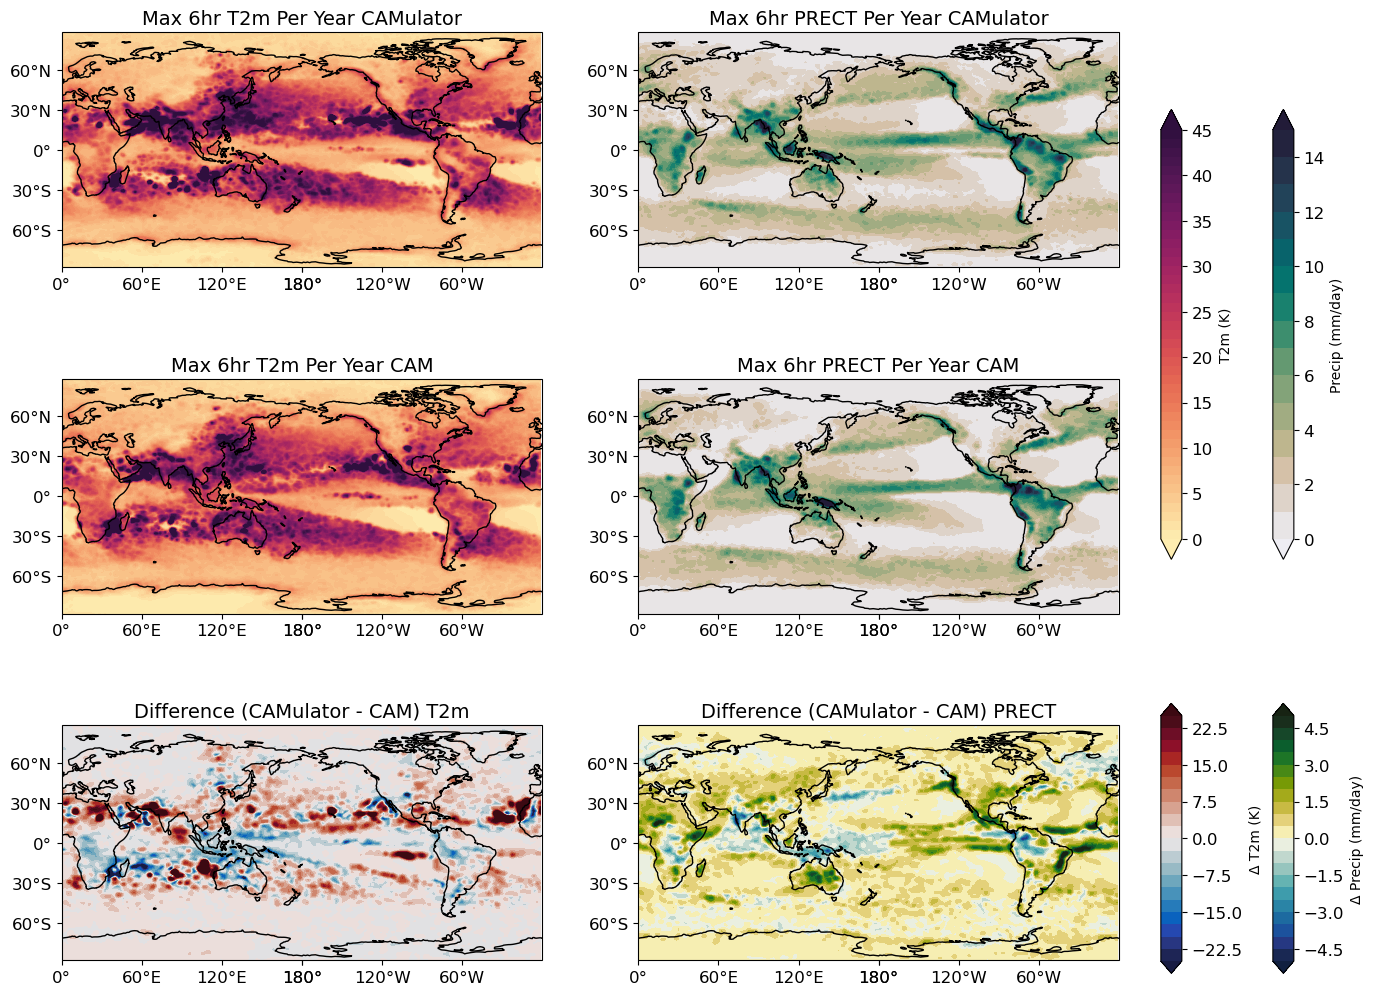

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cmocean
import cmocean.cm as cmo
from scipy.ndimage import gaussian_filter


# Compute annual means for both models
amtpeakmap_smooth1 = gaussian_filter(amtpeakmap1, sigma=sigma)
pdfpeakmap_smooth1 = gaussian_filter(pdfpeakmap1, sigma=sigma)

amtpeakmap_smooth2 = gaussian_filter(amtpeakmap2, sigma=sigma)
pdfpeakmap_smooth2 = gaussian_filter(pdfpeakmap2, sigma=sigma)

# amtpeakmap_smooth3 = gaussian_filter(amtpeakmap3, sigma=sigma)
# pdfpeakmap_smooth3 = gaussian_filter(pdfpeakmap3, sigma=sigma)

# Compute differences (CAMulator - CAM)
diff_amp = gaussian_filter(amtpeakmap_smooth2 - amtpeakmap_smooth1,sigma=sigma)
diff_freq = gaussian_filter(pdfpeakmap_smooth2 - pdfpeakmap_smooth1,sigma=sigma)

amtpeakmap_smooth1 = xr.DataArray(
    amtpeakmap_smooth1.T,
    dims=("latitude", "longitude"),
    coords={"latitude": DSzarr1_TP.latitude, "longitude": DSzarr1_TP.longitude},
    name="amtpeakmap_smooth"
)

pdfpeakmap_smooth1  = xr.DataArray(
    pdfpeakmap_smooth1.T ,
    dims=("latitude", "longitude"),
    coords={"latitude": DSzarr1_TP.latitude, "longitude": DSzarr1_TP.longitude},
    name="pdfpeakmap_smooth"
)

amtpeakmap_smooth2 = xr.DataArray(
    amtpeakmap_smooth2.T,
    dims=("latitude", "longitude"),
    coords={"latitude": DSzarr1_TP.latitude, "longitude": DSzarr1_TP.longitude},
    name="amtpeakmap_smooth"
)

pdfpeakmap_smooth2  = xr.DataArray(
    pdfpeakmap_smooth2.T ,
    dims=("latitude", "longitude"),
    coords={"latitude": DSzarr1_TP.latitude, "longitude": DSzarr1_TP.longitude},
    name="pdfpeakmap_smooth"
)

diff_amp= xr.DataArray(
    diff_amp.T,
    dims=("latitude", "longitude"),
    coords={"latitude": DSzarr1_TP.latitude, "longitude": DSzarr1_TP.longitude},
    name="amtpeakmap_smooth"
)

diff_freq  = xr.DataArray(
    diff_freq.T ,
    dims=("latitude", "longitude"),
    coords={"latitude": DSzarr1_TP.latitude, "longitude": DSzarr1_TP.longitude},
    name="pdfpeakmap_smooth"
)

# Data for visualization
data = [
    amtpeakmap_smooth2, pdfpeakmap_smooth2,
    amtpeakmap_smooth1, pdfpeakmap_smooth1,
    diff_amp, diff_freq,
]
print('plotting')

# Define levels for contour plots
levels_prect = np.linspace(0, 15, 16)  # Precipitation
levels_t2m = np.linspace(0, 45, 46)  # Temperature
levels_diff_t2m = np.linspace(-25, 25, 21)  # Difference in Temperature
levels_diff_prect = np.linspace(-5, 5, 21)  # Difference in Precip

# Create figure with six panels (3 rows, 2 columns)
proj = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(nrows=3, ncols=2, subplot_kw={'projection': proj}, figsize=(14, 18))

# Titles for plots
titles = [
    'Max 6hr T2m Per Year CAMulator',
    'Max 6hr PRECT Per Year CAMulator',
    'Max 6hr T2m Per Year CAM',
    'Max 6hr PRECT Per Year CAM',
    'Difference (CAMulator - CAM) T2m',
    'Difference (CAMulator - CAM) PRECT'
]

num_count = 0

for ax, title, plot_data in zip(axes.flat, titles, data):

    if num_count in [0, 2]:  # Temperature plots
        im_t2m = ax.contourf(
            plot_data.longitude, plot_data.latitude, plot_data,
            levels=levels_t2m,
            transform=ccrs.PlateCarree(),
            cmap=cmo.matter,
            extend='both'
        )
    elif num_count in [1, 3]:  # Precipitation plots
        im_prect = ax.contourf(
            plot_data.longitude, plot_data.latitude, plot_data,
            levels=levels_prect,
            transform=ccrs.PlateCarree(),
            cmap=cmo.rain,
            extend='both'
        )
    else:  # Difference plots (T2m & Precip)
        if num_count == 4:  # T2m Difference
            im_diff_t2m = ax.contourf(
                plot_data.longitude, plot_data.latitude, plot_data,
                levels=levels_diff_t2m,
                transform=ccrs.PlateCarree(),
                cmap=cmo.balance,
                extend='both'
            )
        else:  # Precip Difference
            im_diff_prect = ax.contourf(
                plot_data.longitude, plot_data.latitude, plot_data,
                levels=levels_diff_prect,
                transform=ccrs.PlateCarree(),
                cmap=cmo.delta,
                extend='both'
            )

    ax.coastlines()
    ax.set_title(title, fontsize=14)

    # Set lat/lon ticks with degree symbols
    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.set_extent([0, 360, -88, 88], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(labelsize=12)

    num_count += 1

# Adjust layout and add colorbars
fig.subplots_adjust(right=0.88, wspace=0.2, hspace=-0.5)

# Create colorbars
cbar_ax_t2m = fig.add_axes([0.91, 0.46, 0.015, 0.25])
cbar_t2m = fig.colorbar(im_t2m, cax=cbar_ax_t2m, label='T2m (K)', shrink=0.8)
cbar_t2m.ax.tick_params(labelsize=12)

cbar_ax_prect = fig.add_axes([0.99, 0.46, 0.015, 0.25])
cbar_prect = fig.colorbar(im_prect, cax=cbar_ax_prect, label='Precip (mm/day)', shrink=0.8)
cbar_prect.ax.tick_params(labelsize=12)

cbar_ax_diff_t2m = fig.add_axes([0.91, 0.23, 0.015, 0.15])
cbar_diff_t2m = fig.colorbar(im_diff_t2m, cax=cbar_ax_diff_t2m, label='Δ T2m (K)', shrink=0.8)
cbar_diff_t2m.ax.tick_params(labelsize=12)

cbar_ax_diff_prect = fig.add_axes([0.99, 0.23, 0.015, 0.15])
cbar_diff_prect = fig.colorbar(im_diff_prect, cax=cbar_ax_diff_prect, label='Δ Precip (mm/day)', shrink=0.8)
cbar_diff_prect.ax.tick_params(labelsize=12)

plt.show()
